In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default') 
plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid")

Con el objetivo de obtener un valor numerico que sea proporcional al salario de un aviso, mapeamos de la entidad avisos_detalle las variables categoricas: nivel_laboral, tipo_trabajo, nombre_area a factores numericos para obtener un sueldo estimado como el producto de esos valores... miedo

In [44]:
def get_nivel_laboral_factor(avisos_detalle):
    to_nivel_laboral_factor = {'Senior / Semi-Senior' : 3.0, 'Junior':2.0, 'Otro':1.0,
       'Jefe / Supervisor / Responsable':4.0,
       'Gerencia / Alta Gerencia / Dirección':5.0}
    return avisos_detalle['nivel_laboral'].map(to_nivel_laboral_factor)

def get_tipo_trabajo_factor(avisos_detalle):
    to_tipo_trabajo_factor = {'Full-time' : 4.0, 'Part-time':2.0, 'Pasantia':1.0,'Por Horas':2.0,
       'Temporario':2.0, 'Por Contrato':2.0, 'Teletrabajo':2.0, 'Fines de Semana':1.0, 'Primer empleo':1.0}
    return avisos_detalle['tipo_de_trabajo'].map(to_tipo_trabajo_factor)

def get_nombre_area_factor(avisos_detalle):
    to_nombre_area_factor = pd.read_csv('data/factores_por_area.csv')
    to_nombre_area_factor = to_nombre_area_factor.set_index('nombre_area')['factor_area']
    return avisos_detalle['nombre_area'].map(to_nombre_area_factor)
    
def set_sueldo_estimado(avisos_detalle):
    avisos_detalle['nivel_laboral_nro'] = get_nivel_laboral_factor(avisos_detalle)
    avisos_detalle['tipo_trabajo_nro'] = get_tipo_trabajo_factor(avisos_detalle)
    avisos_detalle['nombre_area_nro'] = get_nombre_area_factor(avisos_detalle)
    avisos_detalle['sueldo_estimado'] = avisos_detalle['nivel_laboral_nro'] * avisos_detalle['tipo_trabajo_nro'] * avisos_detalle['nombre_area_nro']

def get_avisos_detalle():
    avisos_detalle = pd.read_csv('data/fiuba_6_avisos_detalle.csv')
    columns_rename = {'idpostulante': 'id_postulante', 'idaviso': 'id_aviso'}
    avisos_detalle = avisos_detalle.rename(columns=columns_rename)
    set_suledo_estimado(avisos_detalle)
    return avisos_detalle    

def get_postulaciones():
    postulaciones = pd.read_csv('data/fiuba_4_postulaciones.csv')
    columns_rename = {'idaviso': 'id_aviso', 'idpostulante': 'id_postulante', 'fechapostulacion': 'fecha_postulacion'}
    postulaciones = postulaciones.rename(columns=columns_rename)
    postulaciones['fecha_postulacion']=pd.to_datetime(postulaciones['fecha_postulacion'])
    return postulaciones

def get_year_of_birth(postulantes_genero_edad):
    return (pd.to_datetime
            (postulantes_genero_edad['fechanacimiento'], errors='coerce', format='%Y-%m-%d')
            .dt.year)

def get_age(yearOfBirth):
    return 2018 - yearOfBirth
    
def get_age_range(yearOfBirth):
    age = get_age(yearOfBirth)
    if(age<25): return 'Entre 18 y 24'
    if(age<30): return 'Entre 25 y 30'
    if(age<35): return 'Entre 30 y 35'
    if(age<40): return 'Entre 35 y 40'
    if(age<45): return 'Entre 40 y 45'
    if(age<50): return 'Entre 45 y 50'
    return 'Mayor de 50'

def get_order_for_age_range():
    return ['Entre 18 y 24', 'Entre 25 y 30','Entre 30 y 35','Entre 35 y 40','Entre 40 y 45','Entre 45 y 50', 'Mayor de 50']

def get_postulantes_genero_edad():
    postulantes_genero_edad = pd.read_csv('data/fiuba_2_postulantes_genero_y_edad.csv')
    postulantes_genero_edad['año_nacimiento_postulante']=get_year_of_birth(postulantes_genero_edad)
    postulantes_genero_edad['edad_postulante']=postulantes_genero_edad['año_nacimiento_postulante'].map(get_age, na_action=None)
    postulantes_genero_edad['rango_edad_postulante']=postulantes_genero_edad['año_nacimiento_postulante'].map(get_age_range, na_action=None)
    columns_rename = {'idpostulante': 'id_postulante', 'fechanacimiento': 'fecha_nacimiento_postulante', 'sexo': 'genero_postulante'}
    postulantes_genero_edad = postulantes_genero_edad.rename(columns=columns_rename)
    postulantes_genero_edad = postulantes_genero_edad[['id_postulante', 'genero_postulante', 'fecha_nacimiento_postulante', 'edad_postulante', 'rango_edad_postulante']]
    postulantes_genero_edad['genero_postulante'] = postulantes_genero_edad['genero_postulante'].map({'FEM': 'Femenino', 'MASC': 'Masculino', 'NO_DECLARA': 'No declara'})
    #Nos interesan los que indicaron el genero para la historia que queremos contar
    return postulantes_genero_edad[postulantes_genero_edad['genero_postulante']!='No declara']

def get_detalle_postulaciones():
    postulaciones = get_postulaciones()
    avisos = get_avisos_detalle()
    postulantes = get_postulantes_genero_edad()
    detalle_postulaciones = pd.merge(postulantes, postulaciones, on='id_postulante', how='inner') 
    detalle_postulaciones = pd.merge(detalle_postulaciones, avisos, on='id_aviso', how='inner')
    return detalle_postulaciones

def get_top_for(df, categorical_key, top_size):
    top_values = df[categorical_key].value_counts().head(top_size).index
    return df[df[categorical_key].isin(top_values)]


In [45]:
#Verificacion que no perdemos registros al establecer los sueldos estimados
#verificacion que no hay valores no enteros que nos estamos olvidando de mapear
avisos = pd.read_csv('data/fiuba_6_avisos_detalle.csv')
count_avisos_puros = len(avisos)
set_sueldo_estimado(avisos)
if count_avisos_puros != len(avisos):
    print('Estamos perdiendo datos')
    
def check_any_is_null(df, column, message):
    if df[column].isnull().values.any():
        print(message)

check_any_is_null(avisos, 'nivel_laboral_nro', 'No mapeamos bien todos los casos por nivel laboral')
check_any_is_null(avisos, 'tipo_trabajo_nro', 'No mapeamos bien todos los casos por tipo de trabajo')
check_any_is_null(avisos, 'nombre_area_nro', 'No mapeamos bien todos los casos por nombre de area')
check_any_is_null(avisos, 'sueldo_estimado', 'No mapeamos bien todos los sueldos estimados')

avisos[avisos['nombre_area_nro'].isnull()]['nombre_area'].value_counts().index

No mapeamos bien todos los casos por nombre de area
No mapeamos bien todos los sueldos estimados


Index(['Auditoría Médica', 'Farmacia industrial', 'Farmacia comercial',
       'Trabajo social', 'Medicina Laboral', 'Bienestar Estudiantil',
       'Instrumentación quirúrgica', 'Otras Especialidades médicas',
       'Arte y Cultura', 'Quimica'],
      dtype='object')

In [3]:
postulaciones = get_detalle_postulaciones()
postulaciones_mujeres = postulaciones[postulaciones['genero_postulante']=='Femenino']
postulaciones_varones = postulaciones[postulaciones['genero_postulante']=='Masculino']

postulaciones.head()

,id_postulante,genero_postulante,fecha_nacimiento_postulante,edad_postulante,rango_edad_postulante,id_aviso,fecha_postulacion,idpais,titulo,descripcion,...,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa,nivel_laboral_nro,to_tipo_trabajo_nro,factor_area,sueldo_estimado
0,NM5M,Femenino,1970-12-03,48.0,Entre 45 y 50,1112257047,2018-01-15 16:22:34,1,REPRESENTANTES DE ATENCIÓN AL CLIENTE/ RETENCIÓN,"<p><strong><em><span style="""">En </span></em><...",...,NaN,NaN,Part-time,Otro,Atención al Cliente,Eficasia Argentina SA,1.0,2.0,1.1,2.0
1,8krKL,Masculino,1972-11-06,46.0,Entre 45 y 50,1112257047,2018-01-21 09:45:13,1,REPRESENTANTES DE ATENCIÓN AL CLIENTE/ RETENCIÓN,"<p><strong><em><span style="""">En </span></em><...",...,NaN,NaN,Part-time,Otro,Atención al Cliente,Eficasia Argentina SA,1.0,2.0,1.1,2.0
2,EDEpY4,Femenino,1980-05-22,38.0,Entre 35 y 40,1112257047,2018-01-15 09:07:25,1,REPRESENTANTES DE ATENCIÓN AL CLIENTE/ RETENCIÓN,"<p><strong><em><span style="""">En </span></em><...",...,NaN,NaN,Part-time,Otro,Atención al Cliente,Eficasia Argentina SA,1.0,2.0,1.1,2.0
3,1lejrO,Femenino,1968-05-05,50.0,Mayor de 50,1112257047,2018-01-16 06:01:50,1,REPRESENTANTES DE ATENCIÓN AL CLIENTE/ RETENCIÓN,"<p><strong><em><span style="""">En </span></em><...",...,NaN,NaN,Part-time,Otro,Atención al Cliente,Eficasia Argentina SA,1.0,2.0,1.1,2.0
4,Y0MNYJ,Femenino,1977-02-28,41.0,Entre 40 y 45,1112257047,2018-01-16 16:22:36,1,REPRESENTANTES DE ATENCIÓN AL CLIENTE/ RETENCIÓN,"<p><strong><em><span style="""">En </span></em><...",...,NaN,NaN,Part-time,Otro,Atención al Cliente,Eficasia Argentina SA,1.0,2.0,1.1,2.0


In [4]:
avisos = get_avisos_detalle()
avisos.head()

,id_aviso,idpais,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa,nivel_laboral_nro,to_tipo_trabajo_nro,factor_area,sueldo_estimado
0,8725750,1,VENDEDOR/A PROVINCIA DE SANTA FE,<p><strong><strong>Empresa:</strong></strong> ...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial,VENTOR,3.0,4.0,2.4,12.0
1,9240880,1,"Productores Asesores Independiente, para venta...",Agente\r\noficial Selecciona:</span></strong><...,Capital Federal,Buenos Aires,NaN,Full-time,Jefe / Supervisor / Responsable,Comercial,Agencia Oficial Alejandro Arizaga,4.0,4.0,2.4,16.0
2,1002448818,1,Ejecutivo de Cuentas Sr.,<p>Importante empresa del Mercado Asegurador A...,Gran Buenos Aires,Capital Federal,NaN,Full-time,Senior / Semi-Senior,Comercial,Romasanta y Asociados SA,3.0,4.0,2.4,12.0
3,1110319893,1,Vendedores Telefónicos (Part- time),<p><strong>Estamos en busqueda de representant...,Gran Buenos Aires,NaN,NaN,Part-time,Senior / Semi-Senior,Comercial,Directway S.A.,3.0,2.0,2.4,6.0
4,1110640622,1,Agente Inmobiliario para Oficinas RE/MAX en Zo...,"<p>Si te gusta deleitar a tus clientes, brinda...",Capital Federal,NaN,Gobernador Irigoyen 56,Full-time,Senior / Semi-Senior,Comercial,RE/MAX TITANIUM,3.0,4.0,2.4,12.0


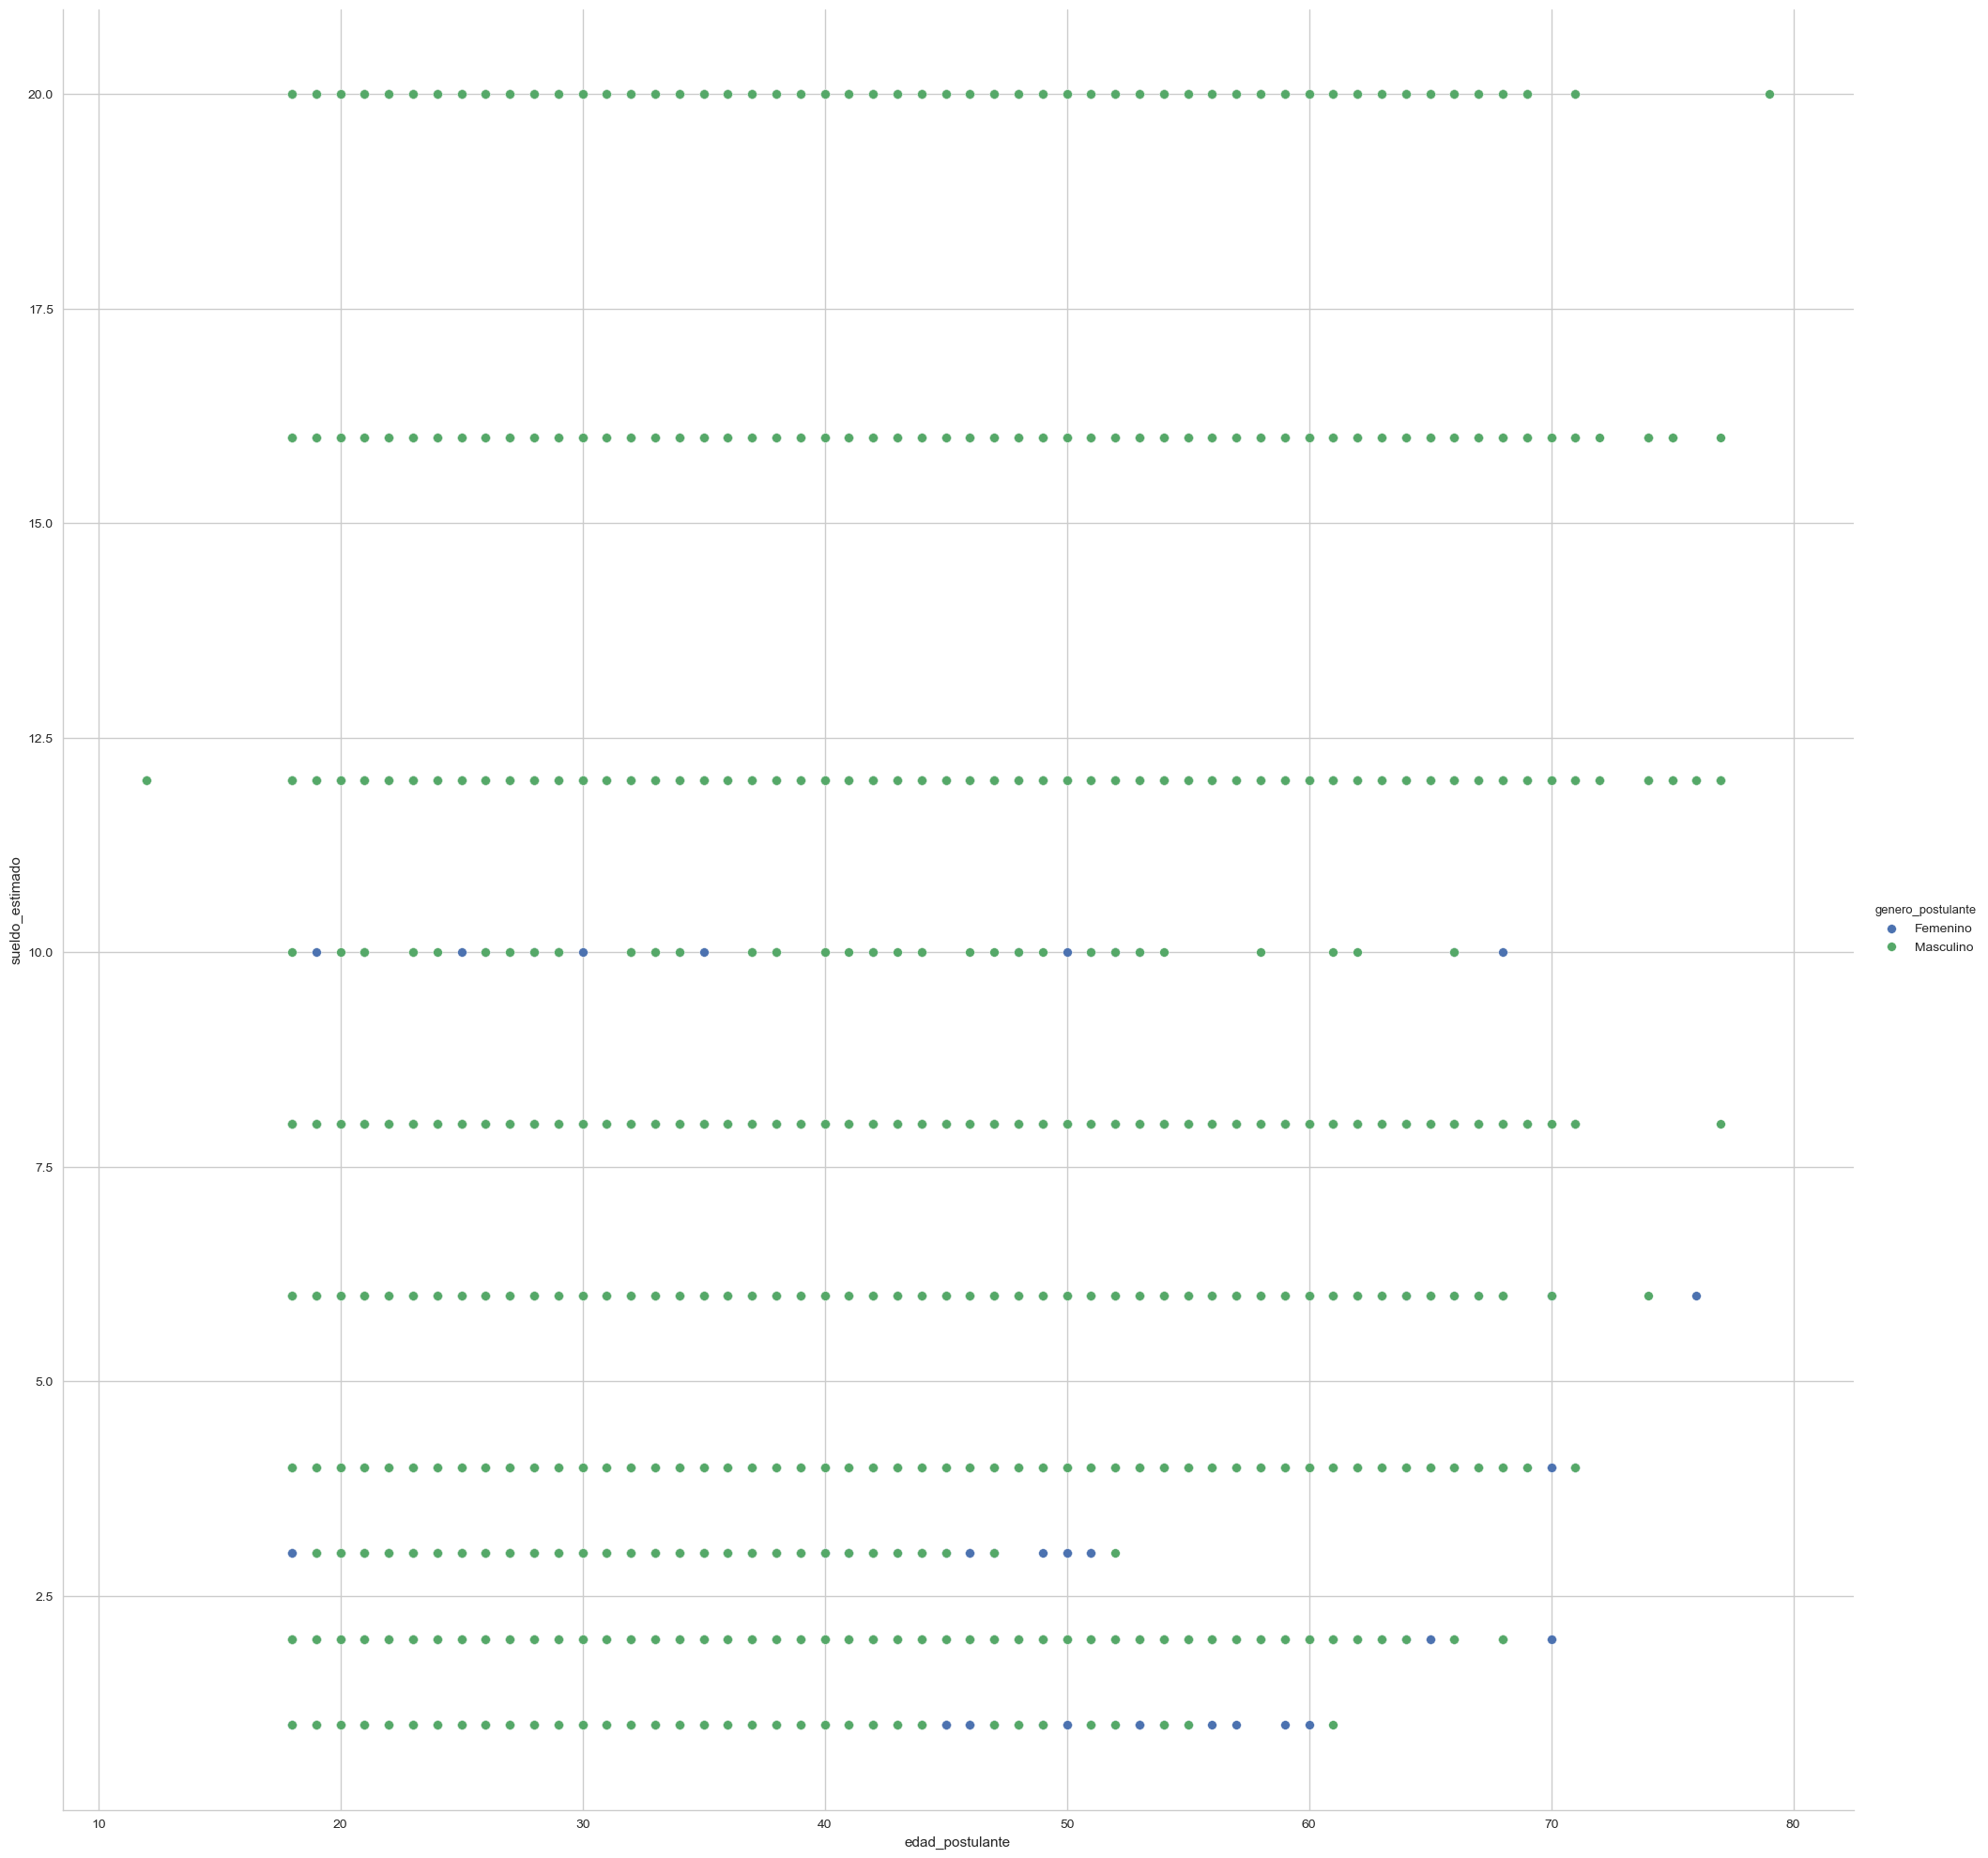

In [46]:
postulaciones_edades_normales = postulaciones[postulaciones['edad_postulante']<90]
g = sns.pairplot(
    data=postulaciones_edades_normales, 
    x_vars=["edad_postulante"], 
    y_vars=["sueldo_estimado"], 
    hue='genero_postulante',
    size=20);


In [15]:
factor_areas = get_values_areas()
factor_areas.head()

,area,factor
0,Ventas,2
1,Administración,2
2,Producción,2
3,Comercial,2
4,Atención al Cliente,1


In [16]:
postulaciones['tipo_de_trabajo'].value_counts()

Full-time          2599565
Part-time           389518
Pasantia             15252
Por Horas            11605
Temporario            9272
Por Contrato          3779
Teletrabajo           3762
Fines de Semana       1849
Primer empleo          122
Name: tipo_de_trabajo, dtype: int64